In [ ]:
!pip install pyyaml==5.1
# Версия torch 1.9.0
!pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html

# 
# Инструкции https://detectron2.readthedocs.io/tutorials/install.html 
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
##### ПЕРЕЗАПУСТИТЕ СРЕДУ ####

  Using cached PyYAML-5.1-cp39-cp39-linux_x86_64.whl
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
roboflow 0.2.5 requires PyYAML>=5.3.1, but you have pyyaml 5.1 which is incompatible.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html


In [ ]:
# Проверка версий
import torch
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9")

1.9.0+cu102 False


In [2]:
# Устанавливаем логгер для детектрона
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Импорты
import numpy as np
import os, json, cv2, random


from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2 import model_zoo

from matplotlib import pyplot as plt

%pip install roboflow
from roboflow import Roboflow
from detectron2.data import MetadataCatalog, DatasetCatalog

Note: you may need to restart the kernel to use updated packages.


In [3]:
#скачиваем датасеты с размеченными объектами с Roboflow
rf = Roboflow(api_key="YSXE7WwzEvf1S2uNYS6O")
project = rf.workspace("dselbrus").project("mask_no_mask-fw9uj")
dataset = project.version(10).download("coco")

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Mask_no_mask-10 in coco:: 100%|██████████| 1843/1843 [00:02<00:00, 703.37it/s] 


In [6]:
## регистрация датасетов
from detectron2.data.datasets import register_coco_instances
register_coco_instances("mask_train", {}, 
                        "train/_annotations.coco.json", 
                        "train")
register_coco_instances("mask_test", {}, 
                         "test/_annotations.coco.json", 
                         "test")

## Сохранение данных для работы сети
mask_metadata = MetadataCatalog.get("mask_train")
mask_dicts = DatasetCatalog.get("mask_train")

mask_metadata = MetadataCatalog.get("mask_test")
mask_dicts = DatasetCatalog.get("mask_test")

WARNING [08/08 16:42:21 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/08 16:42:21 d2.data.datasets.coco]: Loaded 1661 images in COCO format from train/_annotations.coco.json
WARNING [08/08 16:42:21 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[08/08 16:42:21 d2.data.datasets.coco]: Loaded 176 images in COCO format from test/_annotations.coco.json


In [7]:
mask_metadata.thing_classes

['mask-detection', 'mask_weared_incorrect', 'with_mask', 'without_mask']

In [4]:
#DatasetCatalog.pop("mask_train")

<function detectron2.data.datasets.coco.register_coco_instances.<locals>.<lambda>()>

In [5]:
#DatasetCatalog.pop("mask_test")

<function detectron2.data.datasets.coco.register_coco_instances.<locals>.<lambda>()>

In [8]:
cfg = get_cfg()

In [9]:
cfg.MODEL.DEVICE = "cpu"

In [14]:
# Подгружаем обученную модель

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))


cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/home/anna/ds_bootcamp/ds_offline/project_29.07.22/model_final.pth")  # путь к обученной модели
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
# устанавливаем порог обнаружения
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.4  

# создаем объект для построения предсказаний
predictor = DefaultPredictor(cfg)

    # "categories": [
    #     {
    #         "id": 1,
    #         "name": "mask_weared_incorrect",
    #         "supercategory": "mask-detection"
    #     },
    #     {
    #         "id": 2,
    #         "name": "with_mask",
    #         "supercategory": "mask-detection"
    #     },
    #     {
    #         "id": 3,
    #         "name": "without_mask",
    #         "supercategory": "mask-detection"

Тестируем модель

In [22]:
im1 = cv2.imread("images/musk_no_mask.png")
outputs = predictor(im1)

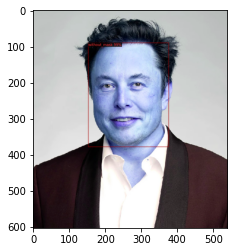

In [23]:
v = Visualizer(im1[:, :, ::-1],
                   metadata=mask_metadata, 
                   scale=0.8)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1]);

In [18]:
im = cv2.imread("images/musk_mask.jpg")
outputs = predictor(im)

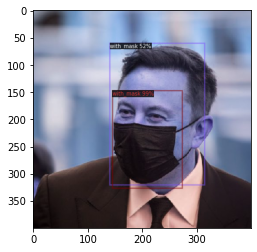

In [19]:
v = Visualizer(im[:, :, ::-1],
                   metadata=mask_metadata, 
                   scale=0.8)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1]);